In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import IPython.display as ipd

import sys
sys.path.append('waveglow/')

from itertools import cycle
import numpy as np
import scipy as sp
from scipy.io.wavfile import write
import pandas as pd
import librosa
import torch

from hparam_setup import create_hparams
from model import Tacotron2, load_model
from waveglow.denoiser import Denoiser
from layers import TacotronSTFT
from data_utils import TextMelLoader, TextMelCollate
from text import cmudict, text_to_sequence
from mellotron_utils import get_data_from_musicxml

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [2]:
def panner(signal, angle):
    angle = np.radians(angle)
    left = np.sqrt(2)/2.0 * (np.cos(angle) - np.sin(angle)) * signal
    right = np.sqrt(2)/2.0 * (np.cos(angle) + np.sin(angle)) * signal
    return np.dstack((left, right))[0]

In [3]:
def plot_mel_f0_alignment(mel_source, mel_outputs_postnet, f0s, alignments, figsize=(16, 16)):
    fig, axes = plt.subplots(4, 1, figsize=figsize)
    axes = axes.flatten()
    axes[0].imshow(mel_source, aspect='auto', origin='bottom', interpolation='none')
    axes[1].imshow(mel_outputs_postnet, aspect='auto', origin='bottom', interpolation='none')
    axes[2].scatter(range(len(f0s)), f0s, alpha=0.5, color='red', marker='.', s=1)
    axes[2].set_xlim(0, len(f0s))
    axes[3].imshow(alignments, aspect='auto', origin='bottom', interpolation='none')
    axes[0].set_title("Source Mel")
    axes[1].set_title("Predicted Mel")
    axes[2].set_title("Source pitch contour")
    axes[3].set_title("Source rhythm")
    plt.tight_layout()

In [4]:
def load_mel(path):
    audio, sampling_rate = librosa.core.load(path, sr=hparams['sampling_rate'])
    audio = torch.from_numpy(audio)
    if sampling_rate != hparams['sampling_rate']:
        raise ValueError("{} SR doesn't match target {} SR".format(
            sampling_rate, stft.sampling_rate))
    audio_norm = audio / hparams['max_wav_value']
    audio_norm = audio_norm.unsqueeze(0)
    audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
    melspec = stft.mel_spectrogram(audio_norm)
    melspec = melspec.cuda()
    return melspec

In [56]:
hparams = create_hparams()
# hparams['sampling_rate']=22050
hparams['verbose']=3
hparams['load_mel_f0_from_disk']=False
hparams['randomize_samples']=False


In [57]:
stft = TacotronSTFT(hparams["filter_length"], hparams["hop_length"], hparams["win_length"],
                    hparams["n_mel_channels"], hparams["sampling_rate"], hparams["mel_fmin"],
                    hparams["mel_fmax"])
print(hparams["sampling_rate"])

24000


## Load Models

In [116]:
checkpoint_path = "models/mellotron_libritts.pt"
checkpoint_path = "my_models/run-Apr16-2228/checkpoint_6500"
checkpoint_path = "my_models/run-Apr18-2318/checkpoint_69000"
mellotron = load_model(hparams).cuda().eval()
mellotron.load_state_dict(torch.load(checkpoint_path)['state_dict'])

<All keys matched successfully>

In [117]:
waveglow_path = 'models/waveglow_256channels_v4.pt'
waveglow = torch.load(waveglow_path)['model'].cuda().eval()
denoiser = Denoiser(waveglow).cuda().eval()

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:563: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


## Define Speakers Set

In [118]:
speaker_ids = TextMelLoader("filelists/libritts_train_clean_100_audiopath_text_sid_atleast5min_val_filelist.txt", hparams).speaker_ids
speakers = pd.read_csv('filelists/libritts_speakerinfo.txt', engine='python',header=None, comment=';', sep=' *\| *', 
                       names=['ID', 'SEX', 'SUBSET', 'MINUTES', 'NAME'])
speakers['MELLOTRON_ID'] = speakers['ID'].apply(lambda x: speaker_ids[x] if x in speaker_ids else -1)
female_speakers = cycle(
    speakers.query("SEX == 'F' and MINUTES > 20 and MELLOTRON_ID >= 0")['MELLOTRON_ID'].sample(frac=1).tolist())
male_speakers = cycle(
    speakers.query("SEX == 'M' and MINUTES > 20 and MELLOTRON_ID >= 0")['MELLOTRON_ID'].sample(frac=1).tolist())

## Setup dataloaders

In [119]:

arpabet_dict = cmudict.CMUDict('data/cmu_dictionary')
audio_paths = 'data/examples_filelist.txt'
audio_paths = 'filelists/libritts_train_clean_100_audiopath_text_sid_atleast5min_val_filelist.txt'
dataloader = TextMelLoader(audio_paths, hparams)#  , speaker_ids=speaker_ids)
datacollate = TextMelCollate(9)

## Load data

In [121]:
file_idx = 1

audio_path, text, sid = dataloader.audiopaths_and_text[file_idx]

# get audio path, encoded text, pitch contour and mel for gst
text_encoded = torch.LongTensor(text_to_sequence(text, hparams['text_cleaners'], arpabet_dict))[None, :].cuda()    
pitch_contour = dataloader[file_idx][3][None].cuda()
mel = load_mel(audio_path)
print(audio_path, text)

# load source data to obtain rhythm using tacotron 2 as a forced aligner
x, y = mellotron.parse_batch(datacollate([dataloader[file_idx]]))

loaded f0 and mel in  00:14.681915
/path_to_libritts/7511/102419/7511_102419_000020_000000.wav Mr. Stewart is the queerest man: instead of letting me enjoy the tableau, he solemnly drove on, saying he would not want any one gawking at him if he were the happy man.
loaded f0 and mel in  00:15.303105


In [122]:
ipd.Audio(audio_path, rate=hparams['sampling_rate'])

# Style Transfer (Rhythm and Pitch Contour)

In [123]:
pitch_contour = pitch_contour-pitch_contour.mean()

In [124]:
inputs, input_lengths, targets, max_len, output_lengths, speaker_ids, f0s, ctxt, ctxt_l = x
print(inputs.shape, targets.shape, f0s.shape, max_len)

torch.Size([1, 151]) torch.Size([1, 80, 945]) torch.Size([1, 1, 945]) 151


In [125]:
for i in range(200):
    mel_outputs, mel_outputs_postnet, gate_outputs, rhythm, dec_out, txt_emb = mellotron.forward(x)
rhythm = rhythm.permute(1, 0, 2)

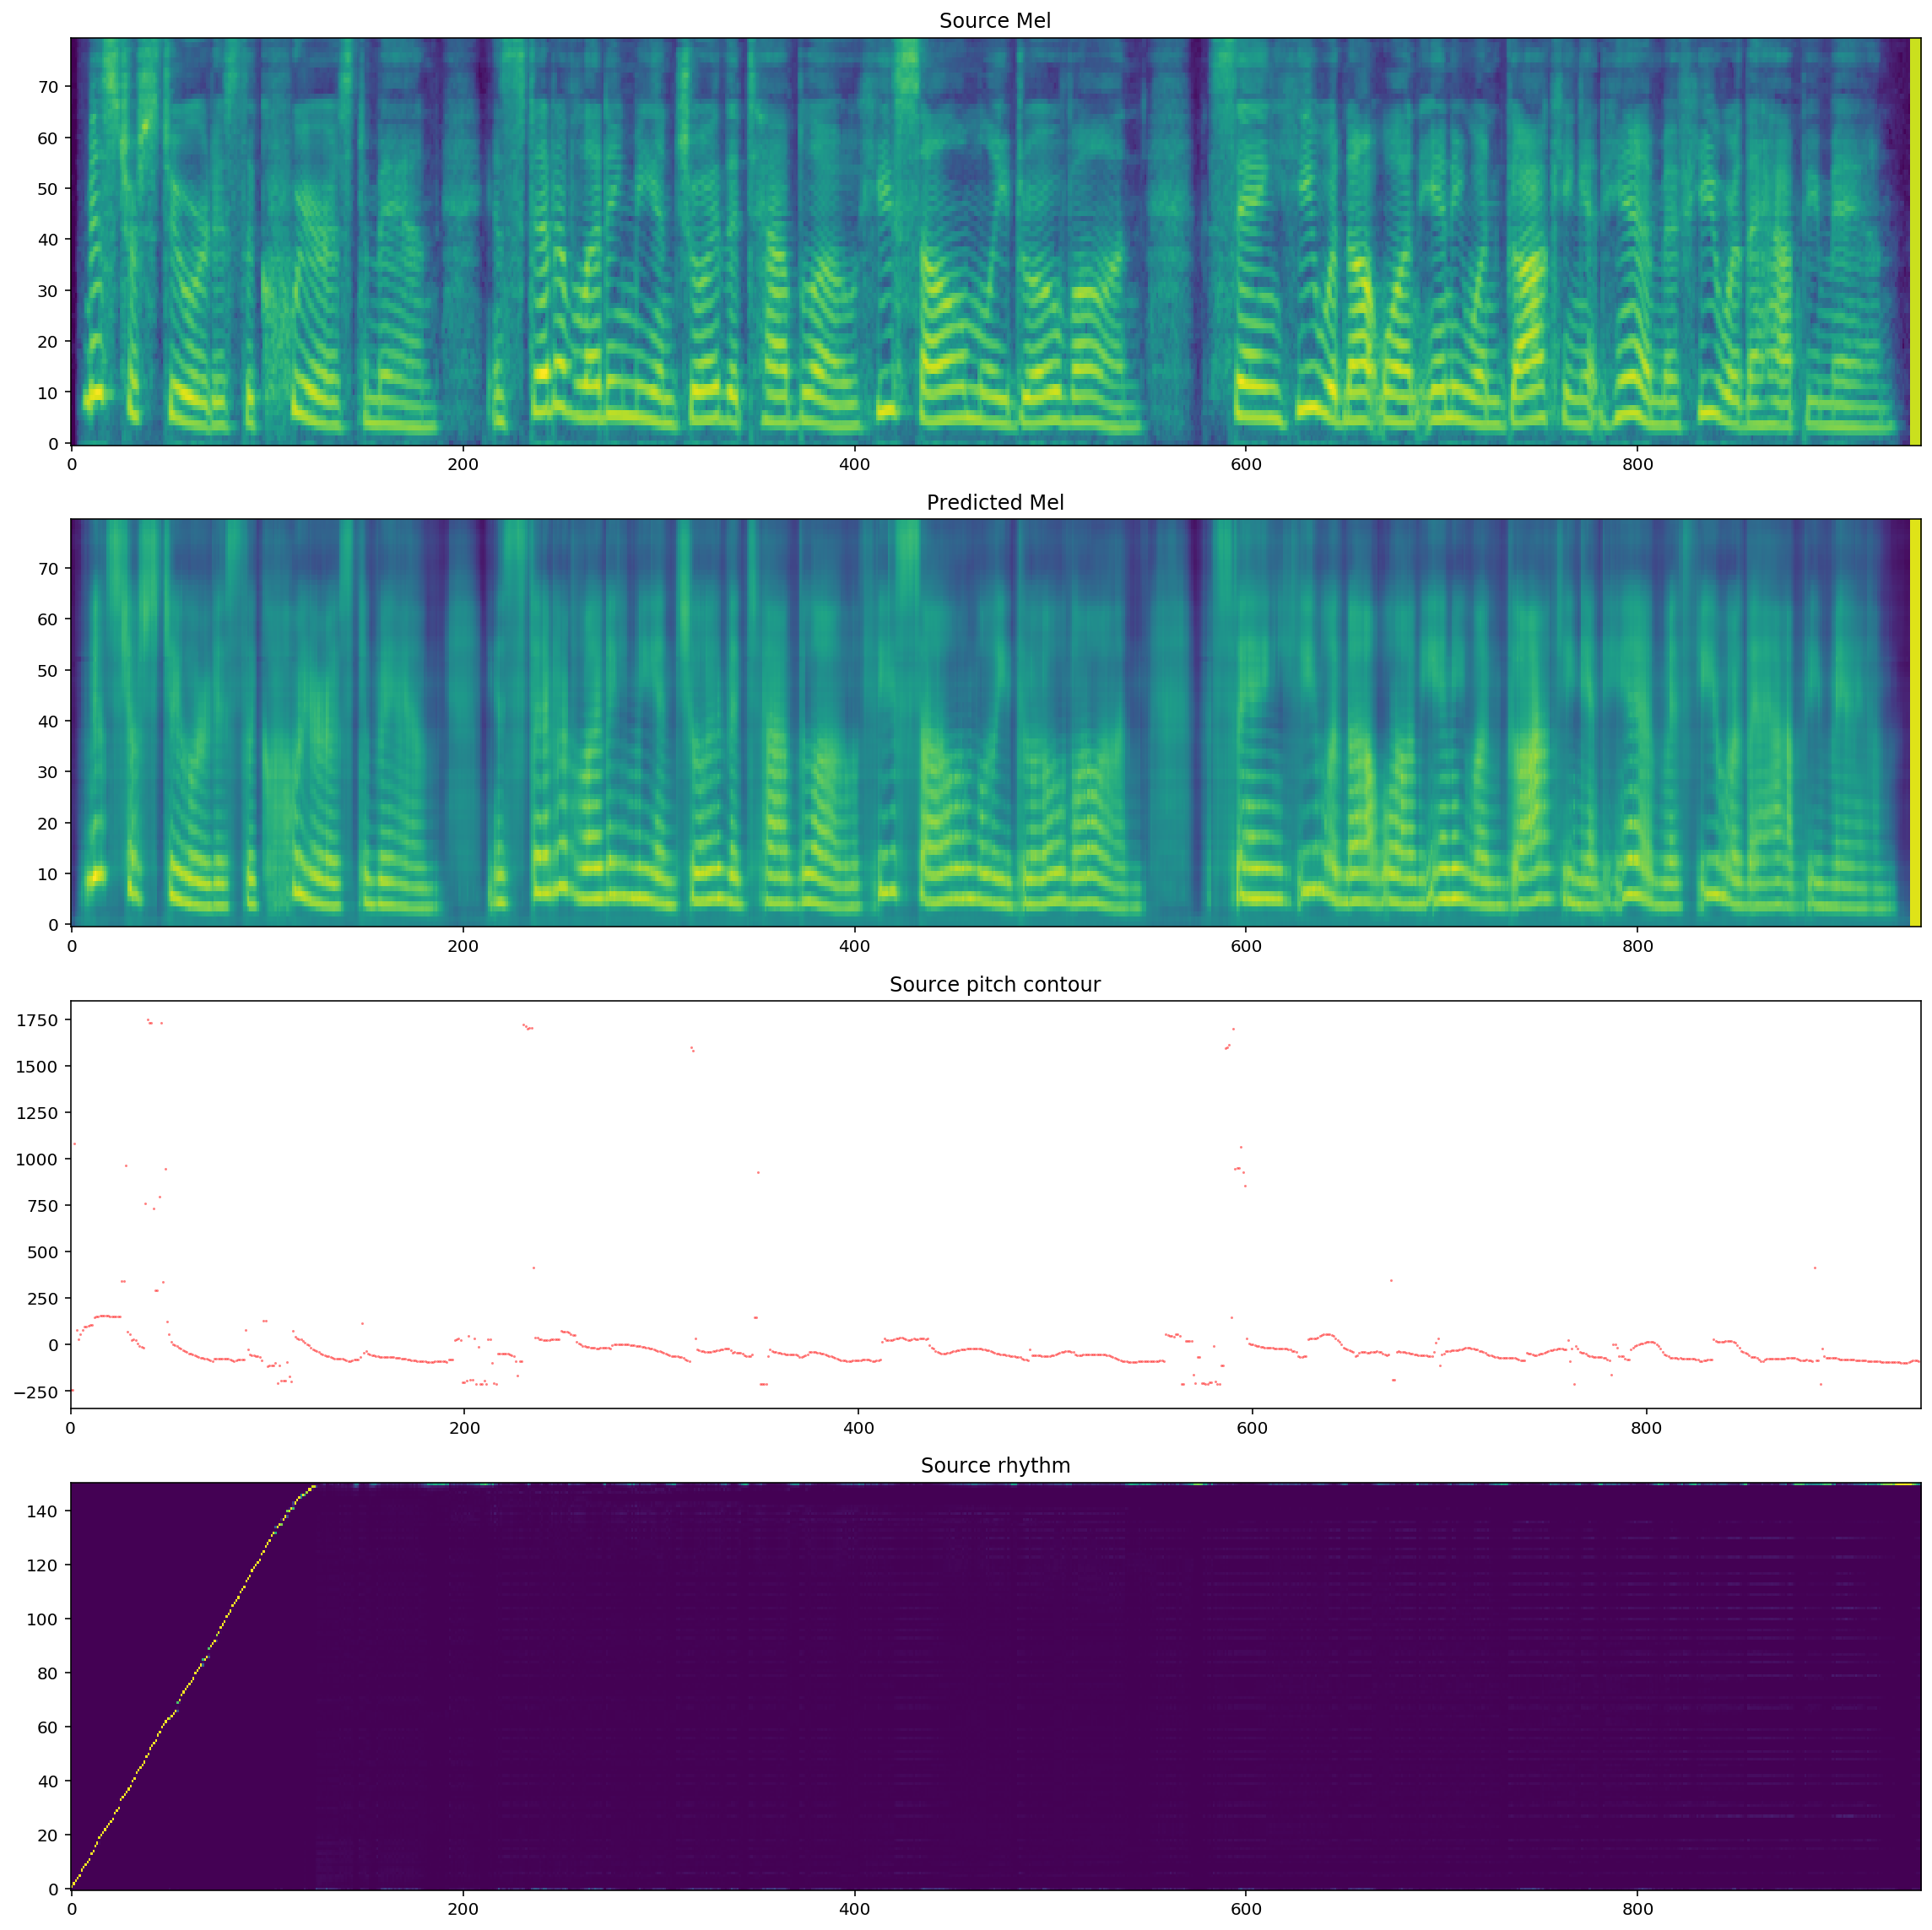

In [170]:
with torch.no_grad():
    audio = denoiser(waveglow.infer(mel_outputs_postnet, sigma=0.8), 0.01)[:, 0]
    
plot_mel_f0_alignment(x[2].data.cpu().numpy()[0],
                      mel_outputs_postnet.data.cpu().numpy()[0],
                      pitch_contour.data.cpu().numpy()[0, 0],
                      rhythm.data.cpu().numpy()[:, 0].T)    
    
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams["sampling_rate"])



In [168]:
with torch.no_grad():
    # get rhythm (alignment map) using tacotron 2
    mel_outputs, mel_outputs_postnet, gate_outputs, rhythm, dec, txt_emb = mellotron.forward(x)
rhythm = rhythm.permute(1, 0, 2)

In [148]:
import math
max = rhythm.max()
min = rhythm.min()
print(rhythm.shape, mel_outputs.shape, max.item(), min.item())
rng = rhythm.size(0)
step =rhythm.size(2)
rhythm2 = torch.zeros(1,rng,step)
for i in range(rng):
    k = (step*i)//rng
    rhythm2[0][i][k]=1
rhythm2 = rhythm2.permute(1,0,2)
print(rhythm2.shape)
rhythm=rhythm2.cuda()    

torch.Size([945, 1, 151]) torch.Size([1, 80, 940]) 1.0 0.0
torch.Size([945, 1, 151])


In [149]:
mel2 = torch.zeros(mel.shape).cuda()

In [150]:
mel2 = mel

In [151]:
speaker_id = next(female_speakers) if np.random.randint(2) else next(male_speakers)
print(speakers.query("MELLOTRON_ID == "+ str(speaker_id))['NAME'])
print(speaker_id)

1537    Jay Bidal
Name: NAME, dtype: object
40


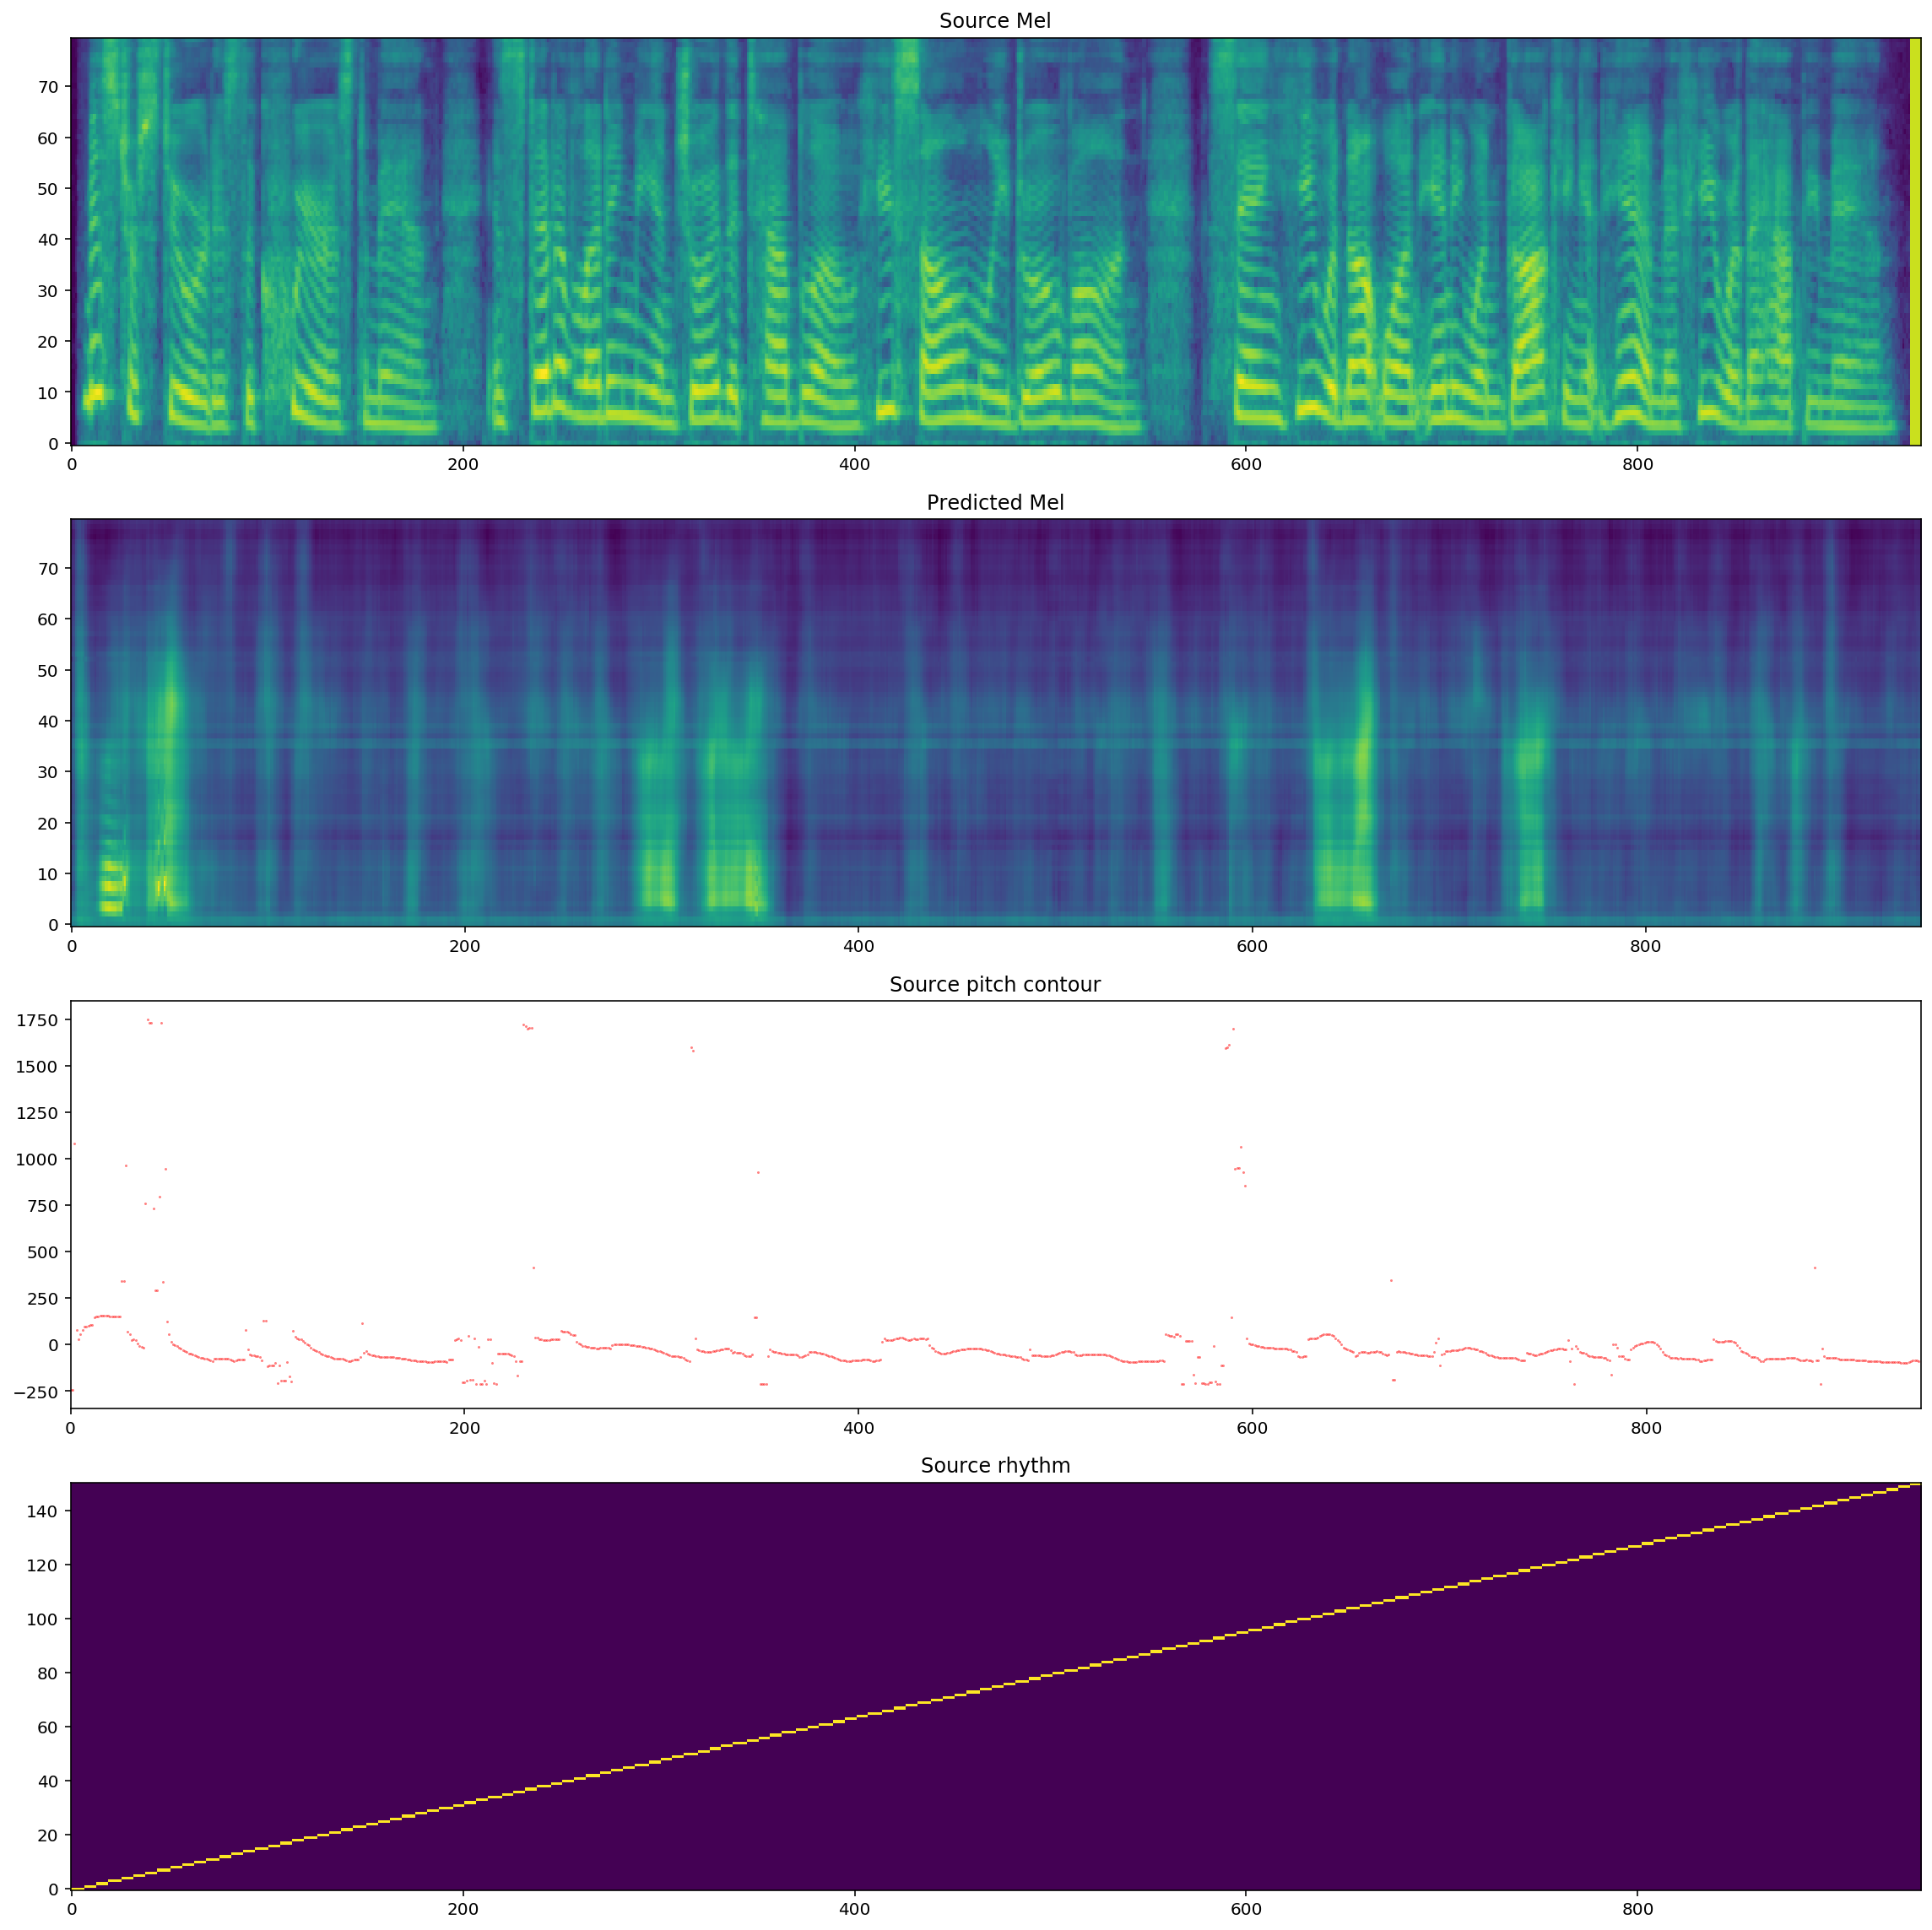

In [152]:

speaker_id = torch.LongTensor([speaker_id]).cuda()


with torch.no_grad():
    mel_outputs, mel_outputs_postnet, gate_outputs, _ = mellotron.inference_noattention(
        (text_encoded, mel2, speaker_id, pitch_contour, rhythm))

plot_mel_f0_alignment(x[2].data.cpu().numpy()[0],
                      mel_outputs_postnet.data.cpu().numpy()[0],
                      pitch_contour.data.cpu().numpy()[0, 0],
                      rhythm.data.cpu().numpy()[:, 0].T)

In [142]:
with torch.no_grad():
    audio = denoiser(waveglow.infer(mel_outputs_postnet, sigma=0.8), 0.01)[:, 0]
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams["sampling_rate"])

# Singing Voice from Music Score

In [133]:
data = get_data_from_musicxml('data/haendel_hallelujah.musicxml', 132, convert_stress=True)
panning = {'Soprano': [-60, -30], 'Alto': [-40, -10], 'Tenor': [30, 60], 'Bass': [10, 40]}

In [134]:
n_speakers_per_part = 4
frequency_scaling = 0.4
n_seconds = 90
audio_stereo = np.zeros((hparams.sampling_rate*n_seconds, 2), dtype=np.float32)
for i, (part, v) in enumerate(data.items()):
    rhythm = data[part]['rhythm'].cuda()
    pitch_contour = data[part]['pitch_contour'].cuda()
    text_encoded = data[part]['text_encoded'].cuda()
    
    for k in range(n_speakers_per_part):
        pan = np.random.randint(panning[part][0], panning[part][1])
        if any(x in part.lower() for x in ('soprano', 'alto', 'female')):
            speaker_id = torch.LongTensor([next(female_speakers)]).cuda()
        else:
            speaker_id = torch.LongTensor([next(male_speakers)]).cuda()
        print("{} MellotronID {} pan {}".format(part, speaker_id.item(), pan))

        with torch.no_grad():
            mel_outputs, mel_outputs_postnet, gate_outputs, alignments_transfer = mellotron.inference_noattention(
                (text_encoded, mel, speaker_id, pitch_contour*frequency_scaling, rhythm))

            audio = denoiser(waveglow.infer(mel_outputs_postnet, sigma=0.8), 0.01)[0, 0]
            audio = audio.cpu().numpy()
            audio = panner(audio, pan)
            audio_stereo[:audio.shape[0]] += audio            
            write("{} {}.wav".format(part, speaker_id.item()), hparams.sampling_rate, audio)

AttributeError: 'HParams' object has no attribute 'sampling_rate'

In [135]:
audio_stereo = audio_stereo / np.max(np.abs(audio_stereo))
write("audio_stereo.wav", hparams.sampling_rate, audio_stereo)
ipd.Audio([audio_stereo[:,0], audio_stereo[:,1]], rate=hparams.sampling_rate)

NameError: name 'audio_stereo' is not defined